# Contextual Bandit Singular Value Decomposition Recommendation Engine
#### Daniel Fay

### Matrix Factorization using Singular Value Decomposition

In [1]:
# Import necessary packages
import pandas as pd
import numpy as np
from sklearn import preprocessing
from scipy.sparse.linalg import svds as svd
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

In [2]:
# Load MovieLens Dataset
ratings_list = [i.strip().split("::") for i in open('../Data/ml-1m/ratings.dat', 'r').readlines()]
users_list = [i.strip().split("::") for i in open('../Data/ml-1m/users.dat', 'r').readlines()]
movies_list = [i.strip().split("::") for i in open('../Data/ml-1m/movies.dat', 'r').readlines()]

ratings_df = pd.DataFrame(ratings_list, columns = ['UserID', 'MovieID', 'Rating', 'Timestamp'], dtype = int)
movies_df = pd.DataFrame(movies_list, columns = ['MovieID', 'Title', 'Genres'])

In [3]:
# Create user-business rating matrix
ratings_na = ratings_df.pivot(index='UserID', columns='MovieID', values='Rating')
ratings_na.head()

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
UserID,,,,,,,,,,,,,,,,,,,,,
1,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Fill NaN with 0
ratings = ratings_na.copy()
ratings.fillna(0, inplace=True)
ratings.head()

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
UserID,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# Normalize Data
ratings_matrix = ratings.as_matrix()
user_ratings_mean = np.mean(ratings_matrix, axis = 1)
ratings_matrix_normalized = ratings_matrix - user_ratings_mean.reshape(-1, 1)

In [6]:
# Define root mean squared error for two matrices
from sklearn.metrics import mean_squared_error
from math import sqrt
def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten()
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, ground_truth))

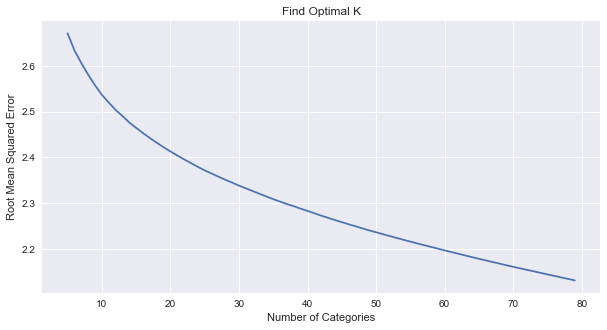

In [10]:
# Find optimal K for Singular Value Decomposition
## K is the number of categories which the matrix is decomposed to 
## (in the movie example it would be the different genres like romance, action etc.)
rm_se = []
for k in range(5,80):
    U, sigma, Vt = svd(ratings_matrix_normalized, k = k)
    sigma = np.diag(sigma)
    ratings_pred = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)
    rm_se.append(rmse(ratings_pred, ratings_matrix))

plt.figure(figsize=(10,5))
plt.plot(range(5,80), rm_se)
plt.xlabel('Number of Categories')
plt.ylabel('Root Mean Squared Error')
plt.title('Find Optimal K')

Choosing the K value is some what arbitrary in this case. I chose 30.

In [11]:
# Select top 1000 users and top 150 movies
ratings = ratings.ix[ratings_na.isnull().sum(axis=1).sort_values().index[:1000]]
ratings = ratings.ix[:, ratings_na.isnull().sum().sort_values().index[:150]]

In [12]:
# Normalize Data
ratings_matrix = ratings.as_matrix()
user_ratings_mean = np.mean(ratings_matrix, axis = 1)
ratings_matrix_normalized = ratings_matrix - user_ratings_mean.reshape(-1, 1)

In [13]:
# Predict complete rating matrix
U, sigma, Vt = svd(ratings_matrix_normalized, k = 30)
sigma = np.diag(sigma)
ratings_pred = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)
ratings_pred_df = pd.DataFrame(ratings_pred, columns = ratings.columns, index=ratings.index)
ratings_pred_df.head()

MovieID,2858,260,1196,1210,480,2028,589,2571,1270,593,...,2011,2321,920,2324,2012,1090,47,1500,1370,1954
UserID,,,,,,,,,,,,,,,,,,,,,
4169,5.051282,4.581226,4.228054,4.021049,4.591333,4.165108,3.638355,4.068839,4.221898,4.755369,...,3.411326,4.246425,4.955864,5.286935,3.517212,4.485983,4.050345,4.017778,3.125044,3.333563
1680,4.839838,3.758534,3.710672,3.594270,3.575791,2.869968,3.515554,2.771802,3.772376,4.250523,...,3.653844,4.536232,4.184155,1.155891,3.714735,1.793213,5.067545,4.761693,3.413935,2.735437
4277,4.808078,5.198680,5.048980,4.731296,4.841765,5.195883,5.049970,5.213394,5.079567,4.969381,...,4.435252,4.807855,4.186061,4.683166,4.270037,5.438701,4.670218,4.811775,4.219465,5.128804
1941,2.781839,5.035394,4.806141,4.614981,4.994216,4.183183,4.219454,4.146749,4.744429,5.042069,...,3.383929,3.832360,3.668720,0.294269,3.997192,1.785781,3.190135,2.068683,3.378638,2.326771
1181,3.338895,3.927598,4.037718,3.476966,3.795832,3.320319,4.760811,4.448685,2.915372,3.258323,...,2.640612,2.841749,2.870892,3.040624,2.763535,3.682756,2.925524,3.261588,3.719875,3.095274


In [14]:
# Scale rating predictions from 0 to 5
ratings_pred_df = pd.DataFrame(preprocessing.MinMaxScaler((0,5)).fit_transform(ratings_pred_df))
ratings_pred_df.head()

,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
0,3.687826,3.637319,3.344527,3.522719,3.868856,3.329164,2.980691,3.234479,3.550013,3.681132,...,3.442705,3.723534,4.359241,4.348564,3.202317,3.845728,3.637445,3.830630,3.612237,2.949192
1,3.559906,3.082167,2.956960,3.179081,3.178369,2.458415,2.893428,2.356283,3.228246,3.318242,...,3.611593,3.900010,3.924087,2.308654,3.331238,2.217782,4.246029,4.319960,3.820341,2.605223
2,3.540692,4.053976,3.959479,4.094602,4.039130,4.022174,3.983781,4.009434,4.163933,3.834966,...,4.155764,4.065414,3.925162,4.050423,3.693675,4.421705,4.008311,4.352903,4.400610,3.981597
3,2.314851,3.943791,3.777569,4.000947,4.142784,3.341316,3.393618,3.287230,3.924041,3.887215,...,3.423625,3.471390,3.633442,1.883185,3.515593,2.213289,3.122788,2.548559,3.794914,2.370208
4,2.651861,3.196252,3.201948,3.084629,3.327979,2.761195,3.778306,3.491665,2.614803,2.605035,...,2.905982,2.868163,3.183560,3.239336,2.710402,3.360127,2.964474,3.333225,4.040727,2.812158


In [11]:
# Define LinUCB contextual bandit algorithm
def LinUCB(Vt, ratings_pred_df, user, trials, delta):
    context_vectors = pd.DataFrame(Vt.T)
    user_movies = ratings_pred_df.iloc[user].sort_values(ascending=False)
    alpha = 1 + np.sqrt((np.log(2/delta))/2)
    t = 0
    regret_list = []

    while t < trials:
        if t == 0:
            p_list = []
            for ix, X in context_vectors.iterrows():
                A = np.identity(len(Vt))
                b = np.zeros(len(Vt))
                theta = np.dot(np.linalg.inv(A), b)
                p = np.dot(theta.T, X) + alpha*(np.sqrt(np.dot(np.dot(X.T, np.linalg.inv(A)), X)))
                p_list.append((p, ix))
            arm = max(p_list)[1]
            payoff = ratings_pred_df.iloc[user,arm]
            A = A + np.dot(X, X.T)
            b = b + payoff*X
            max_payoff = max(user_movies)
            regret = max_payoff - payoff
            regret_list.append(regret)
            context_vectors = context_vectors.drop(user_movies.argmax())
            user_movies = user_movies.drop(user_movies.argmax())

        else:
            ix = 0
            p_list = []
            for ix, X in context_vectors.iterrows():
                theta = np.dot(np.linalg.inv(A), b)
                p = np.dot(theta.T, X) + alpha*(np.sqrt(np.dot(np.dot(X.T, np.linalg.inv(A)), X)))
                p_list.append((p, ix))
            arm = max(p_list)[1]
            context_vectors = context_vectors.drop(user_movies.argmax())
            max_payoff = max(user_movies)
            payoff = ratings_pred_df.iloc[user,arm]
            A = A + np.dot(X, X.T)
            b = b + payoff*X
            regret = max_payoff - payoff  
            regret_list.append(regret)
            user_movies = user_movies.drop(user_movies.argmax())
            
        t = t + 1
    return regret_list

In [48]:
regret = []
regret_trial = []
regret_df = pd.DataFrame()
deltas = [.25, .5, .75]

for delta in deltas:
    for trials in range(1,100):
        for users in range(0,10):
            regret_trial.append(np.mean(LinUCB(Vt, ratings_pred_df, users, trials, delta)))
        regret.append(np.mean(regret_trial))
    regret_df['delta ' + str(delta)] = regret
    regret = []

In [ ]:
regret_df.to_csv('../Data/results_99t_10u.csv')

In [ ]:
regret_df = pd.read_csv('../Data/results_99t_10u.csv')

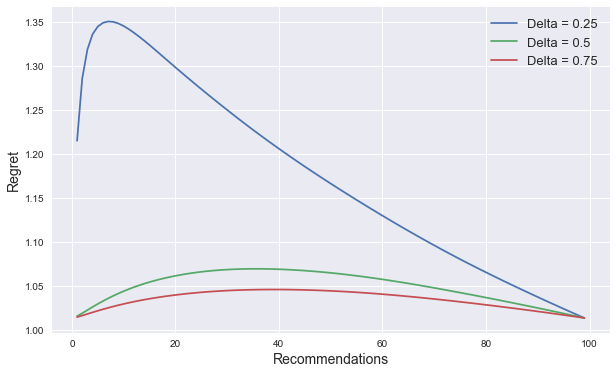

In [49]:
plt.figure(figsize=(10,6))

for i, delta in zip(range(len(regret_df.columns)), deltas):
    plt.plot(range(1, len(regret_df)+1), regret_df.iloc[:,i], label='Delta = '+str(delta))

plt.legend(fontsize=13)
plt.xlabel('Recommendations', fontsize=14)
plt.ylabel('Regret', fontsize=14)
#plt.title('50 Recommendations for 100 users', fontsize=20)